In [1]:
# import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
import math


# NN
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2, ResNet101V2
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# NORMAL
image_folder_normal = 'chest_xray/chest_xray/train/NORMAL/'

# List all image files in the folder
image_files_normal = sorted([f for f in os.listdir(image_folder_normal) if f.endswith(('jpeg'))])

# Initialize lists to store file names and image data
vec_normal = []
image_arrays_normal = []

# Loop through each image file and process
for image_file in image_files_normal:
    # Load image
    img = Image.open(os.path.join(image_folder_normal, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')

    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_normal.append(img_array)
    vec_normal.append(image_file)

# Create a pandas DataFrame
df_normal = pd.DataFrame({
    'file_name': [image_folder_normal + item for item in vec_normal],
    'image_array': image_arrays_normal,
    'label': 'NORMAL'
})

# BACTERIA

image_folder_pneumonia = 'chest_xray/chest_xray/train/PNEUMONIA/'

# List all image files in the folder
image_files_bacteria = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'bacteria' in f.lower()])

# Initialize lists to store file names and image data
vec_bacteria = []
image_arrays_bacteria = []

# Loop through each image file and process
for image_file in image_files_bacteria:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_bacteria.append(img_array)

    # Append file name and image data to lists
    vec_bacteria.append(image_file)

# Create a pandas DataFrame
df_bacteria = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in vec_bacteria],
    'image_array': image_arrays_bacteria,
    'label': 'BACTERIA'
})

# VIRUS

image_files_virus = sorted([f for f in os.listdir(image_folder_pneumonia) if f.endswith(('jpeg')) and 'virus' in f.lower()])

# Initialize lists to store file names and image data
file_names_virus = []
image_arrays_virus = []

# Loop through each image file and process
for image_file in image_files_virus:
    # Load image
    img = Image.open(os.path.join(image_folder_pneumonia, image_file))
    img = img.resize((224, 224)) 
    img = img.convert('L')
    # Convert image to numpy array
    img_array = np.array(img)
    image_arrays_virus.append(img_array)

    # Append file name and image data to lists
    file_names_virus.append(image_file)

# Create a pandas DataFrame
df_virus = pd.DataFrame({
    'file_name': [image_folder_pneumonia + item for item in file_names_virus],
    'image_array': image_arrays_virus,
    'label': 'VIRUS'
})

df_combined = pd.DataFrame({
    'file_name': df_normal['file_name'].tolist() + df_bacteria['file_name'].tolist() + df_virus['file_name'].tolist(),
    'image_array': df_normal['image_array'].tolist() + df_bacteria['image_array'].tolist() + df_virus['image_array'].tolist(),
    'label': df_normal['label'].tolist() + df_bacteria['label'].tolist() + df_virus['label'].tolist()
})

# 1. Data 1: Simplest case

In [7]:
# Calculation Functions

def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/10)*(x-123))

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0

bright_matrix = df_combined['image_array']
X = brightness_f(bright_matrix)
P, W, Y1, Y0 = assign(X)
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]


## 1. ipw 1

In [9]:
ipw_1 = W_0/P_0 - (1-W_0)/(1-P_0)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_1 * Yfull_0)
print(ipw_estimate)

0.8631663230162795


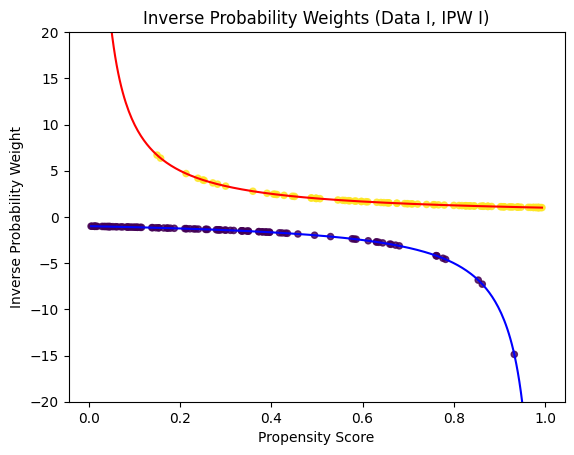

In [10]:
#x = np.array(range(0,220))

x_vals = np.linspace(min(P_0), max(P_0), 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)


plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data I, IPW I)')
plt.ylim(-20, 20)
plt.show()


In [11]:
# sampling distribution

# 1. IPW1
pes1 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    P_0s = np.array(P[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # bootstrap

    ipw_1s = W_0s/P_0s - (1-W_0s)/(1-P_0s)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_1s * Yfull_0s)
    pes1.append(ipw_estimates)

    pes1_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)

        X_0_boot = X_0s[j]
        P_0_boot = P_0s[j]
        W_0_boot = W_0s[j]
        Y1_0_boot = Y1_0s[j]
        Y0_0_boot = Y0_0s[j]
        ipw_1s_boot = W_0_boot/P_0_boot - (1-W_0_boot)/(1-P_0_boot)
        Yfull_0s_boot = Y1_0_boot*W_0_boot + Y0_0_boot*(1-W_0_boot)
        ipw_estimates_boot = np.mean(ipw_1s_boot * Yfull_0s_boot)
        pes1_boot.append(ipw_estimates_boot)
    pes1_boot = np.array(pes1_boot)
    bootstd.append(np.std(pes1_boot))

pes1 = np.array(pes1)
samplestd = np.std(pes1)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes1]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes1))

coverage: 0.93
sample std: 0.19789206036428691
expected std: 0.18591633786195544
exp est: 1.0438017882991564


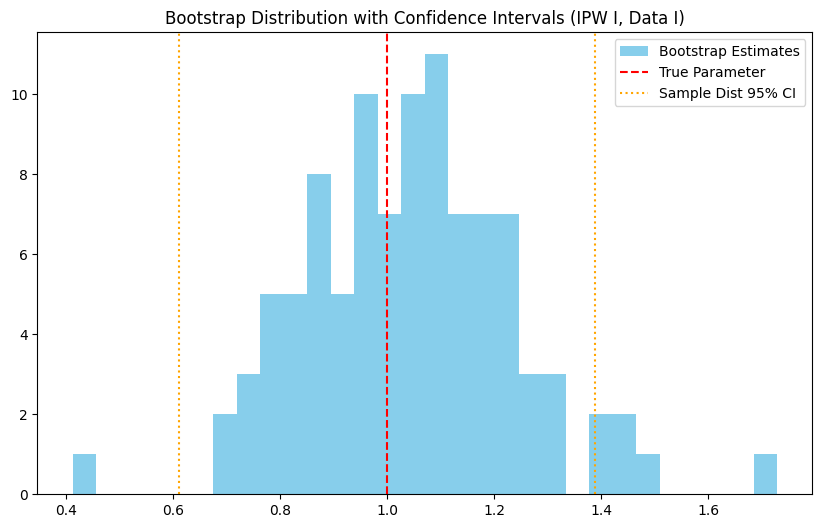

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(pes1, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# Plot all error bars (bootstrapped CIs)
# for i, (point_est, std) in enumerate(zip(pes1, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW I, Data I)')

plt.legend()
plt.show()

## IPW 2

In [13]:
from sklearn.linear_model import LogisticRegression

X_t0 = np.array([X_0]).T
logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_t0, W_0)
P_hat = logistic_model.predict_proba(X_t0)[:,1]

ipw_2 = W_0/P_hat - (1-W_0)/(1-P_hat)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_2 * Yfull_0)
print(ipw_estimate)

0.8977854478006523


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1193623865.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1193623865.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


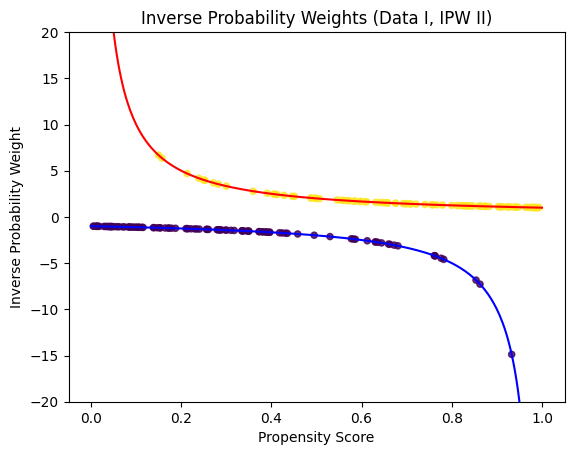

In [14]:
# x = np.array(range(0,220))
# plt.scatter(X_0, ipw_2, c = W_0,alpha = .5, s =10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data I, IPW II)')
# plt.ylim(-40,40)
#x = np.array(range(0,220))

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)


plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data I, IPW II)')
plt.ylim(-20, 20)
plt.show()


In [15]:
# sampling distribution

pes2 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    X_t0 = X_0s.reshape(-1,1)
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_t0, W_0s)
    P_hats = logistic_model.predict_proba(X_t0)[:,1]

    ipw_2s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_2s * Yfull_0s)
    pes2.append(ipw_estimates)

    pes2_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        X_0s_bootT = X_0s_boot.reshape(-1,1)
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_0s_bootT, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_0s_bootT)[:,1]
        ipw_2s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_2s_boot * Yfull_0s_boot)
        pes2_boot.append(ipw_estimates_boot)
    pes2_boot = np.array(pes2_boot)
    bootstd.append(np.std(pes2_boot))

pes2 = np.array(pes2)
samplestd = np.std(pes2)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes2]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes2))

coverage: 0.99
sample std: 0.2838890947434423
expected std: 0.1898759982768942
exp est: 1.0659606454061867


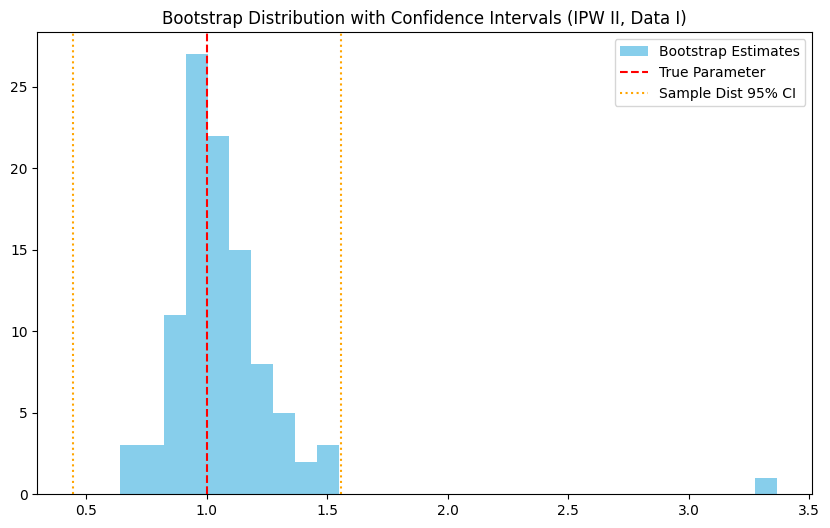

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(pes2, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# # Plot all error bars (bootstrapped CIs)
# for i, (point_est, std) in enumerate(zip(pes2, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW II, Data I)')

plt.legend()
plt.show()

## IPW 3

In [17]:
from sklearn.linear_model import Lasso

def brightness_weight_f(X_pixels, W_pixel):
    model = Lasso(alpha=1, max_iter= 10000, random_state=123)
    model.fit(X_pixels, W_pixel)
    pixel_weights = model.coef_
    weighted_brightness = np.dot(X_pixels, pixel_weights)
    
    return weighted_brightness

In [18]:
X_weight = []
pixels_per_image = 224 * 224 
X_pixels = np.zeros((200, pixels_per_image))
j = 0
for i in random_index:
    X_pixels[j] = df_combined['image_array'][i].flatten()
    j += 1

X_weight = brightness_weight_f(X_pixels, W_0)
X_t = X_weight.reshape(-1,1)
logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_t, W_0)
P_hat_2 = logistic_model.predict_proba(X_t)[:,1]

ipw_3 = W_0/P_hat_2 - (1-W_0)/(1-P_hat_2)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_3 * Yfull_0)
print(ipw_estimate)

0.7657314316496024


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1695587483.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1695587483.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


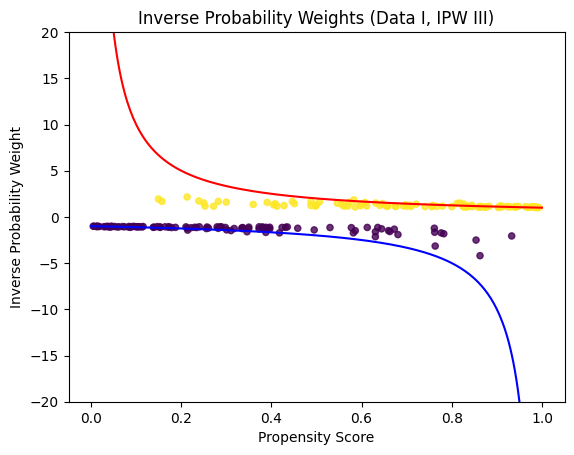

In [19]:
# x = np.array(range(0,220))
# plt.scatter(X_0, ipw_3, c = W_0,alpha = .5, s =10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data I, IPW III)')
# plt.ylim(-40,40)


x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_3, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data I, IPW III)')
plt.ylim(-20, 20)
plt.show()

In [20]:
# sampling distribution

pes3 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    idx = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[idx])
    W_0s = np.array(W[idx])
    Y1_0s = np.array(Y1[idx])
    Y0_0s = np.array(Y0[idx])
    j = 0
    for i in random_index:
        X_pixels[j] = df_combined['image_array'][i].flatten()
        j += 1
    X_weight = brightness_weight_f(X_pixels, W_0s)
    X_t0 = X_weight.reshape(-1,1)
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_t0, W_0s)
    P_hats = logistic_model.predict_proba(X_t0)[:,1]

    ipw_3s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_3s * Yfull_0s)
    pes3.append(ipw_estimates)

    pes3_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200),200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        X_weight_boot = X_weight[j]
        X_0s_bootT = X_weight_boot.reshape(-1,1)
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_0s_bootT, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_0s_bootT)[:,1]
        ipw_3s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_3s_boot * Yfull_0s_boot)
        pes3_boot.append(ipw_estimates_boot)
    pes3_boot = np.array(pes3_boot)
    bootstd.append(np.std(pes3_boot))

pes3 = np.array(pes3)
samplestd = np.std(pes3)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes3]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes3))

coverage: 0.71
sample std: 0.07222015503117583
expected std: 0.06744056206239651
exp est: 0.8937297687628982


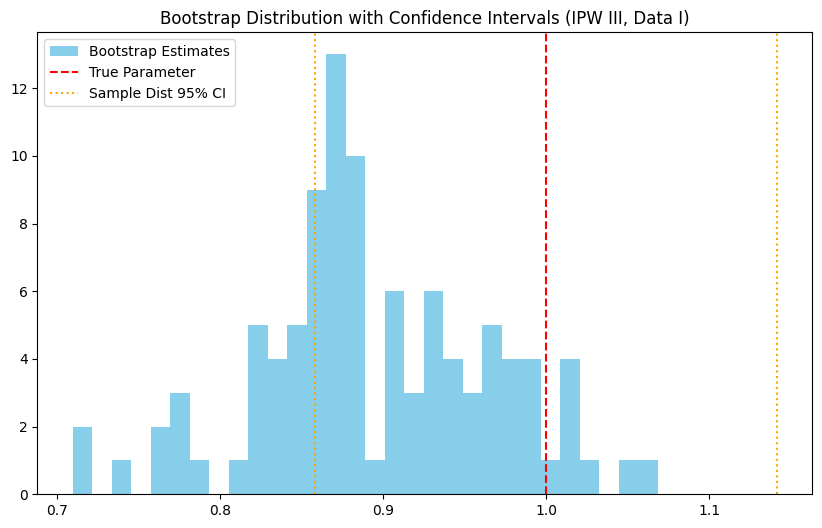

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(pes3, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# # Plot all error bars (bootstrapped CIs)
# for i, (point_est, std) in enumerate(zip(pes3, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW III, Data I)')

plt.legend()
plt.show()

# Data 2: Label + Brightness

In [49]:
def brightness_f(x):
  return np.array([np.mean(i) for i in x])

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/15)*(x-123))

def assign_by_group(x, l):
  
    beta0 = -5
    beta1 = 1
    beta2 = 1
    beta3 = -1

    Xl_i = beta0 + beta1 * x + beta2 * (l == 'BACTERIA') + beta3 * (l == 'VIRUS')
    p_i = propensity_score(Xl_i)
    np.random.seed(0)
    w_i = np.random.binomial(1, p_i)

    gamma_0 = 0
    
    gammas = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', -1, -1))
    taus = np.where(l == 'NORMAL', 0, np.where(l == 'BACTERIA', 1, -1))

    y_0 = gamma_0 + gammas + p_i
    y_1 = gamma_0 + gammas + p_i + taus

    return p_i, w_i, y_1, y_0

L = df_combined['label']

P, W, Y1, Y0 = assign_by_group(X, L)
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]
L_0 = L[random_index] 

## IPW 1

In [50]:
true = np.mean(Y1 - Y0)

print('true:', true)

true: 0.2271855828220859


In [24]:
ipw_1 = W_0/P_0 - (1-W_0)/(1-P_0)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_1 * Yfull_0)
print(ipw_estimate)

0.3629531016811302


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2470776624.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2470776624.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


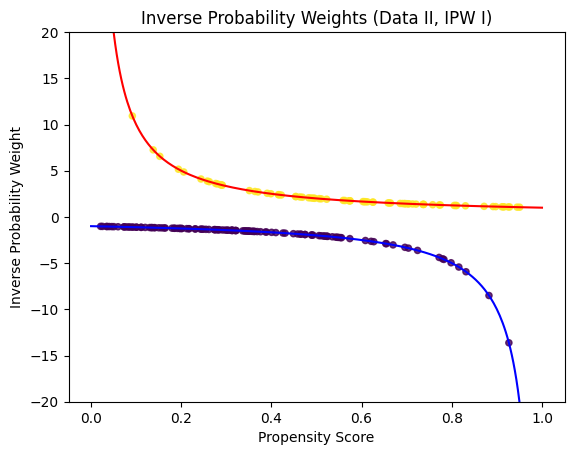

In [25]:
# x = np.array(range(0,220))
# plt.scatter(X_0, ipw_1, c = W_0,alpha = .5, s =10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data II, IPW I)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data II, IPW I)')
plt.ylim(-20, 20)
plt.show()

In [26]:
# sampling distribution

# 1. IPW1
pes1 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    P_0s = np.array(P[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    
    # bootstrap

    ipw_1s = W_0s/P_0s - (1-W_0s)/(1-P_0s)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_1s * Yfull_0s)
    pes1.append(ipw_estimates)

    pes1_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)

        X_0_boot = X_0s[j]
        P_0_boot = P_0s[j]
        W_0_boot = W_0s[j]
        Y1_0_boot = Y1_0s[j]
        Y0_0_boot = Y0_0s[j]
        ipw_1s_boot = W_0_boot/P_0_boot - (1-W_0_boot)/(1-P_0_boot)
        Yfull_0s_boot = Y1_0_boot*W_0_boot + Y0_0_boot*(1-W_0_boot)
        ipw_estimates_boot = np.mean(ipw_1s_boot * Yfull_0s_boot)
        pes1_boot.append(ipw_estimates_boot)
    pes1_boot = np.array(pes1_boot)
    bootstd.append(np.std(pes1_boot))

pes1 = np.array(pes1)
samplestd = np.std(pes1)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r =  true- 1.96*samplestd, true+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes1]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes1))

coverage: 0.95
sample std: 0.1371831251656239
expected std: 0.1316987754408712
exp est: 0.25406357322439577


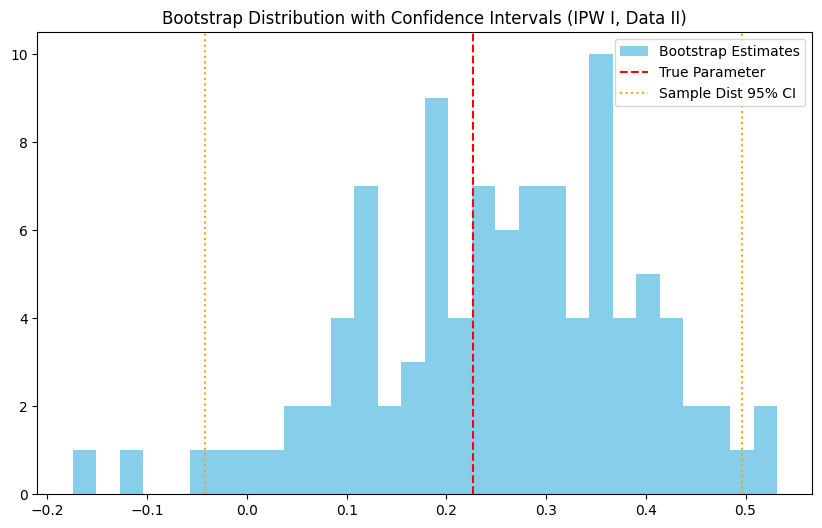

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(pes1, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# Plot all error bars (bootstrapped CIs)
# for i, (point_est, std) in enumerate(zip(pes1, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW I, Data II)')

plt.legend()
plt.show()

## IPW 2

In [28]:
label_dummies = pd.get_dummies(L_0, drop_first=False)  
X_features = np.column_stack((X_0, label_dummies['BACTERIA'], label_dummies['VIRUS']))
logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_features, W_0)
P_hat = logistic_model.predict_proba(X_features)[:,1]

ipw_2 = W_0/P_hat - (1-W_0)/(1-P_hat)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_2 * Yfull_0)
print(ipw_estimate)

0.3377536183972872


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2421083664.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2421083664.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


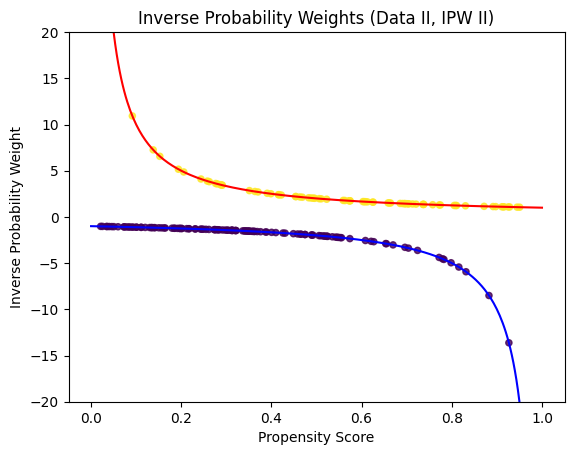

In [29]:
# x = np.array(range(0,220))
# plt.scatter(X_0, ipw_2, c = W_0,alpha = .5, s =10)
# plt.plot(x, 1 / propensity_score(x), color='red', label='Ideal IPW (Treated)')
# plt.plot(x, 1 / (propensity_score(x)-1), color='blue', label='Ideal IPW (Control)')
# plt.title('Inverse Probability Weights (Data II, IPW II)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data II, IPW II)')
plt.ylim(-20, 20)
plt.show()

In [30]:
# sampling distribution

pes2 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    L_0s = np.array(L[i])
    label_dummies = pd.get_dummies(L_0s, drop_first=False)  
    X_features = np.column_stack((X_0s, label_dummies['BACTERIA'], label_dummies['VIRUS']))  
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_features, W_0s)
    P_hats = logistic_model.predict_proba(X_features)[:,1]

    ipw_2s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_2s * Yfull_0s)
    pes2.append(ipw_estimates)

    pes2_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        L_0s_boot = L_0s[j]
        label_dummies = pd.get_dummies(L_0s_boot, drop_first=False)
        X_features_boot = np.column_stack((X_0s_boot, label_dummies['BACTERIA'], label_dummies['VIRUS']))
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_features_boot, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_features_boot)[:,1]
        ipw_2s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_2s_boot * Yfull_0s_boot)
        pes2_boot.append(ipw_estimates_boot)
    pes2_boot = np.array(pes2_boot)
    bootstd.append(np.std(pes2_boot))

pes2 = np.array(pes2)
samplestd = np.std(pes2)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = true-1.96*samplestd, true+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes2]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes2))

coverage: 0.96
sample std: 0.11618595647751198
expected std: 0.09973637302961903
exp est: 0.24296309557955698


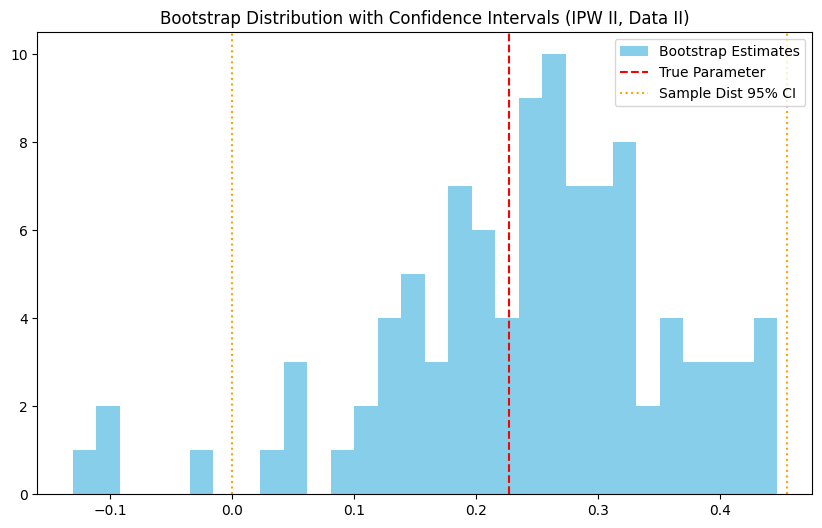

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(pes2, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# # Plot all error bars (bootstrapped CIs)
# for i, (point_est, std) in enumerate(zip(pes2, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW II, Data II)')

plt.legend()
plt.show()

## IPW 3

In [51]:
X_weight = []
pixels_per_image = 224 * 224 
X_pixels = np.zeros((200, pixels_per_image))
j = 0
for i in random_index:
    X_pixels[j] = df_combined['image_array'][i].flatten()
    j += 1

X_weight = brightness_weight_f(X_pixels, W_0)
X_t = X_weight.reshape(-1,1)

label_dummies = pd.get_dummies(L_0, drop_first=False)
X_features = np.column_stack((X_t, label_dummies['BACTERIA'], label_dummies['VIRUS']))


logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_features, W_0)
P_hat_2 = logistic_model.predict_proba(X_features)[:,1]

ipw_3 = W_0/P_hat_2 - (1-W_0)/(1-P_hat_2)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_3 * Yfull_0)
print(ipw_estimate)

0.3033781487545731


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/560565533.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/560565533.py:11: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


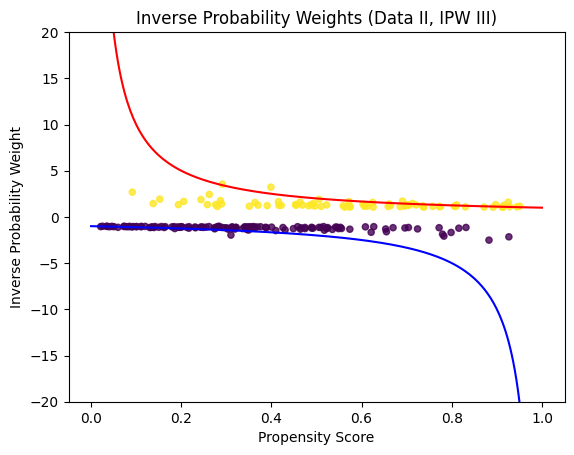

In [52]:
# x = np.array(range(0,220))
# plt.scatter(X_0, ipw_3, c = W_0,alpha = .5, s =10)
# plt.plot(x, 1 / propensity_score(x), color='red', label='Ideal IPW (Treated)')
# plt.plot(x, 1 / (propensity_score(x)-1), color='blue', label='Ideal IPW (Control)')
# plt.title('Inverse Probability Weights (Data II, IPW III)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores

inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_3, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data II, IPW III)')
plt.ylim(-20, 20)
plt.show()

In [53]:
# sampling distribution

pes3 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    idx = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X[idx])
    W_0s = np.array(W[idx])
    Y1_0s = np.array(Y1[idx])
    Y0_0s = np.array(Y0[idx])
    L_0s = np.array(L[idx])
    j = 0
    for i in random_index:
        X_pixels[j] = df_combined['image_array'][i].flatten()
        j += 1
    X_weight = brightness_weight_f(X_pixels, W_0s)
    X_t0 = X_weight.reshape(-1,1)
    label_dummies = pd.get_dummies(L_0s, drop_first=False)
    X_features = np.column_stack((X_t0, label_dummies['BACTERIA'], label_dummies['VIRUS']))
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_features, W_0s)
    P_hats = logistic_model.predict_proba(X_features)[:,1]

    ipw_3s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_3s * Yfull_0s)
    pes3.append(ipw_estimates)

    pes3_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        X_weight_boot = X_weight[j]
        X_0s_bootT = X_weight_boot.reshape(-1,1)
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_0s_bootT, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_0s_bootT)[:,1]
        ipw_3s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_3s_boot * Yfull_0s_boot)
        pes3_boot.append(ipw_estimates_boot)
    pes3_boot = np.array(pes3_boot)
    bootstd.append(np.std(pes3_boot))

pes3 = np.array(pes3)
samplestd = np.std(pes3)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = true - 1.96*samplestd, true+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes3]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes3))

coverage: 0.68
sample std: 0.05788526570634493
expected std: 0.06768076903865898
exp est: 0.3089459052891305


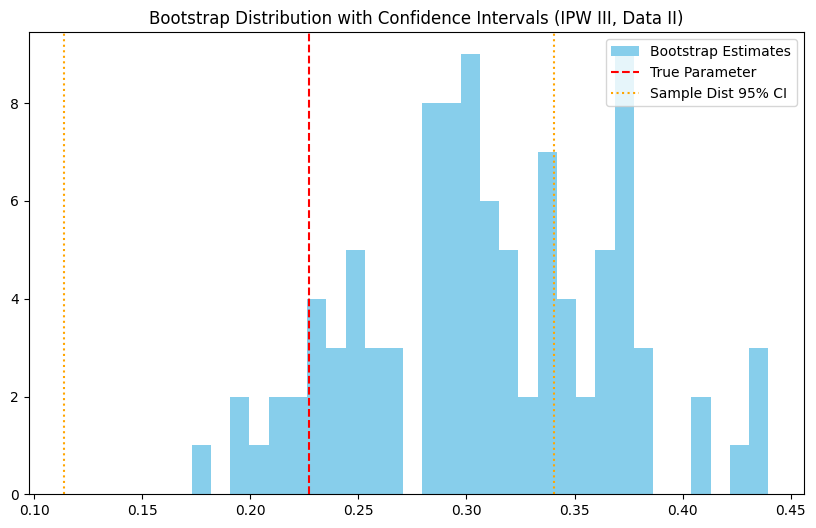

In [54]:
plt.figure(figsize=(10, 6))
plt.hist(pes3, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(true, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes3, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW III, Data II)')

plt.legend()
plt.show()

# Data 3: Filtered Image

In [36]:

from scipy.signal import convolve2d
filter = np.array([[-1, -1, -1], 
                   [-1,  8, -1], 
                   [-1, -1, -1]])

n = 5216
H, W = 224, 224
filtered_features = np.zeros((n, H, W))

def filter_image(image):
    return convolve2d(image, filter, mode='same', boundary='fill', fillvalue=0)

for i in tqdm(range(n)):
    img = df_combined['image_array'][i]  # assume shape (224, 224)
    filtered_img = filter_image(img)
    filtered_features[i] = filtered_img**2  # store squared filtered image

print(filtered_features.shape)

def brightness_f(x):
  return np.array([np.mean(i) for i in x])


X_filter = brightness_f(filtered_features)
mu = np.mean(X_filter)
print(X_filter.shape)

def inv_logit(x):
  return 1 / (1 + np.exp(-x))

def propensity_score(x):
  return inv_logit((1/500)*(x-mu)) 

def assign(x, y_1 = 1, y_0 = 0):
  p = propensity_score(x)
  # seeding
  np.random.seed(0)
  w = np.random.binomial(1, p)
  y1 = y_1 + p
  y0 = y_0 + p
  return p, w, y1, y0



P, W, Y1, Y0 = assign(X_filter)
np.random.seed(0)
random_index = np.random.choice(range(5216), 200, replace=False)
X_0 = X_filter[random_index]
P_0 = P[random_index]
W_0 = W[random_index]
Y1_0 = Y1[random_index]
Y0_0 = Y0[random_index]

100%|██████████| 5216/5216 [00:06<00:00, 752.79it/s]


(5216, 224, 224)
(5216,)


## IPW 1

In [37]:
ipw_1 = W_0/P_0 - (1-W_0)/(1-P_0)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_1 * Yfull_0)
print(ipw_estimate)

1.006746489316341


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2563761400.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2563761400.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


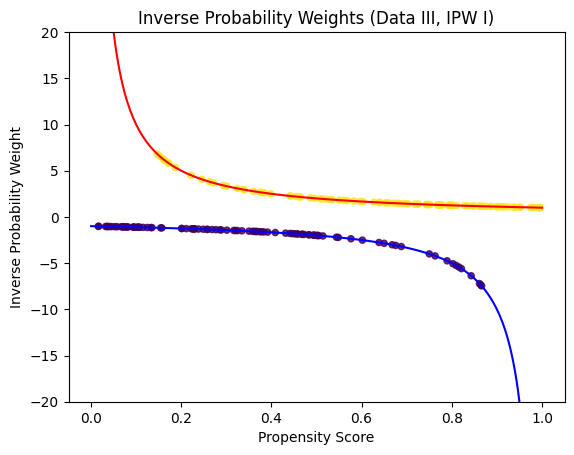

In [38]:
# x = np.array(range(0,6000))
# plt.scatter(X_0, ipw_1, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data III, IPW I)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data III, IPW I)')
plt.ylim(-20, 20)
plt.show()

In [39]:
# sampling distribution

# 1. IPW1
pes1 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X_filter[i])
    P_0s = np.array(P[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])

    # bootstrap

    ipw_1s = W_0s/P_0s - (1-W_0s)/(1-P_0s)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_1s * Yfull_0s)
    pes1.append(ipw_estimates)

    pes1_boot = []
    
    for s2 in range(0, 100):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)

        X_0_boot = X_0s[j]
        P_0_boot = P_0s[j]
        W_0_boot = W_0s[j]
        Y1_0_boot = Y1_0s[j]
        Y0_0_boot = Y0_0s[j]
        ipw_1s_boot = W_0_boot/P_0_boot - (1-W_0_boot)/(1-P_0_boot)
        Yfull_0s_boot = Y1_0_boot*W_0_boot + Y0_0_boot*(1-W_0_boot)
        ipw_estimates_boot = np.mean(ipw_1s_boot * Yfull_0s_boot)
        pes1_boot.append(ipw_estimates_boot)
    pes1_boot = np.array(pes1_boot)
    bootstd.append(np.std(pes1_boot))

pes1 = np.array(pes1)
samplestd = np.std(pes1)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes1]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes1))

coverage: 0.94
sample std: 0.19523219881241985
expected std: 0.17975774771624653
exp est: 1.0089060800029315


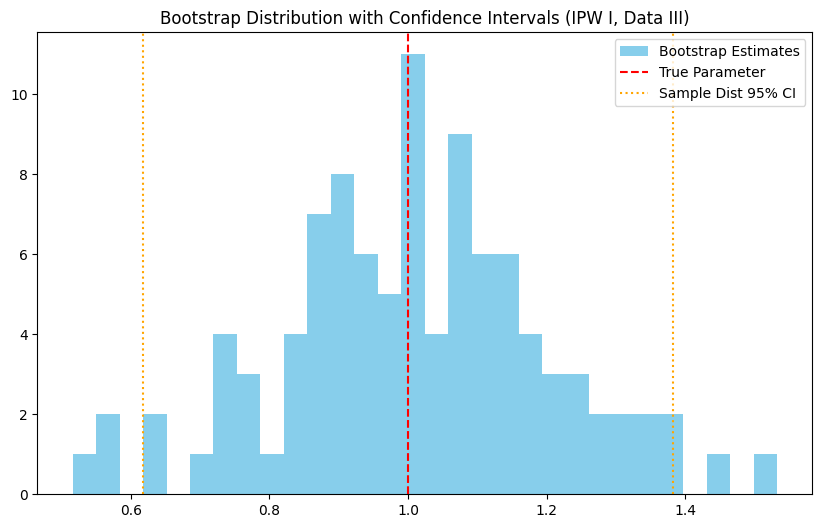

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(pes1, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes1, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW I, Data III)')

plt.legend()
plt.show()

## IPW 2

In [41]:
from sklearn.linear_model import LogisticRegression

X_t0 = np.array([X_0]).T
logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_t0, W_0)
P_hat = logistic_model.predict_proba(X_t0)[:,1]

ipw_2 = W_0/P_hat - (1-W_0)/(1-P_hat)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_2 * Yfull_0)
print(ipw_estimate)

0.9976202158256635


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1306455618.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/1306455618.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


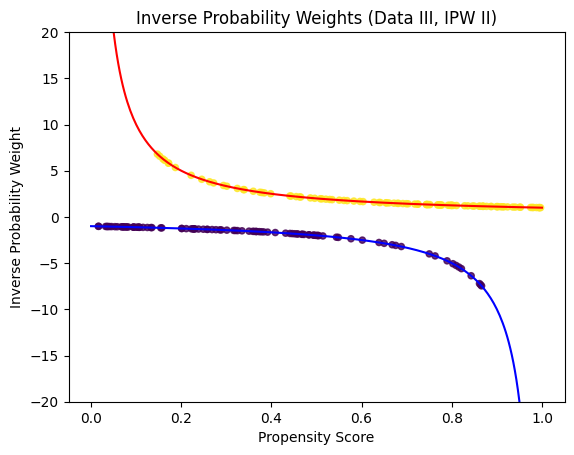

In [42]:
# x = np.array(range(0,6000))
# plt.scatter(X_0, ipw_2, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data III, IPW II)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_1, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data III, IPW II)')
plt.ylim(-20, 20)
plt.show()

In [43]:
# sampling distribution

pes2 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    i = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X_filter[i])
    W_0s = np.array(W[i])
    Y1_0s = np.array(Y1[i])
    Y0_0s = np.array(Y0[i])
    X_t0 = X_0s.reshape(-1,1)
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_t0, W_0s)
    P_hats = logistic_model.predict_proba(X_t0)[:,1]

    ipw_2s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_2s * Yfull_0s)
    pes2.append(ipw_estimates)

    pes2_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        X_0s_bootT = X_0s_boot.reshape(-1,1)
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_0s_bootT, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_0s_bootT)[:,1]
        ipw_2s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_2s_boot * Yfull_0s_boot)
        pes2_boot.append(ipw_estimates_boot)
    pes2_boot = np.array(pes2_boot)
    bootstd.append(np.std(pes2_boot))

pes2 = np.array(pes2)
samplestd = np.std(pes2)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes2]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes2))

coverage: 0.95
sample std: 0.09192901090901982
expected std: 0.09102027834097778
exp est: 1.0238657418920332


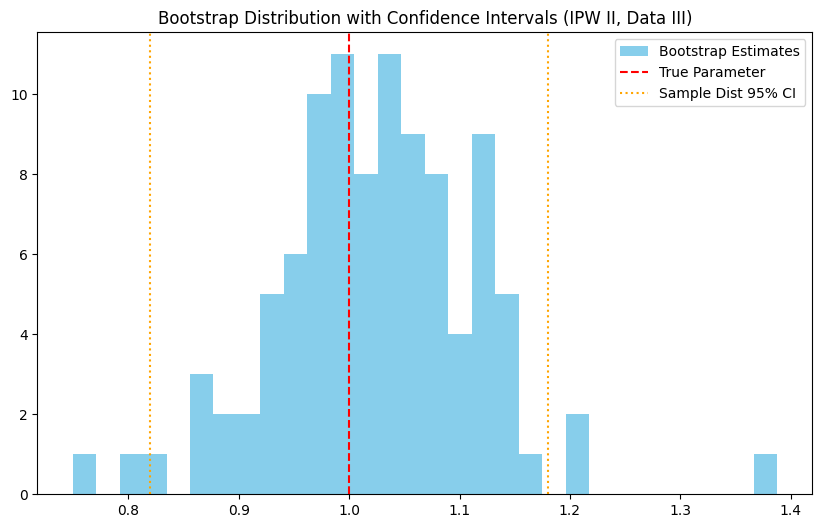

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(pes2, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes2, bootstd)):
#     plt.errorbar(x=point_est, y=i/10, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW II, Data III)')

plt.legend()
plt.show()

## IPW 3

In [45]:
X_weight = []
pixels_per_image = 224 * 224 
X_pixels = np.zeros((200, pixels_per_image))
j = 0
for i in random_index:
    X_pixels[j] = df_combined['image_array'][i].flatten()
    j += 1

X_weight = brightness_weight_f(X_pixels, W_0)
X_t = X_weight.reshape(-1,1)
logistic_model = LogisticRegression(random_state=123)
logistic_model.fit(X_t, W_0)
P_hat_2 = logistic_model.predict_proba(X_t)[:,1]

ipw_3 = W_0/P_hat_2 - (1-W_0)/(1-P_hat_2)
Yfull_0 = Y1_0*W_0 + Y0_0*(1-W_0)
ipw_estimate = np.mean(ipw_3 * Yfull_0)
print(ipw_estimate)

0.8125026692211286


/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2928275425.py:9: RuntimeWarning: divide by zero encountered in divide
  inv_p = 1 / x_vals
/var/folders/gp/hkzmqsm94sx2hsnb5ms2k4_r0000gn/T/ipykernel_1859/2928275425.py:10: RuntimeWarning: divide by zero encountered in divide
  inv_1_minus_p = 1 / (x_vals - 1)


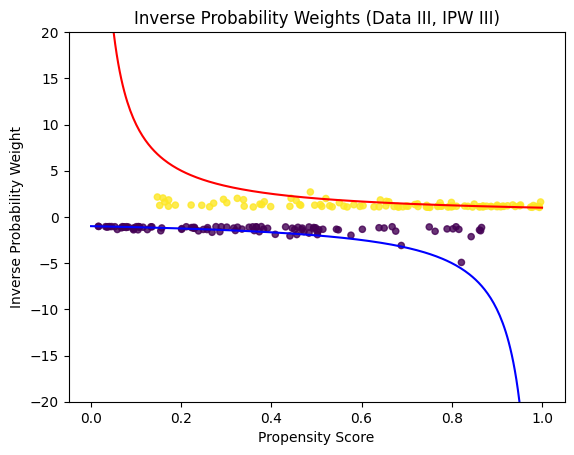

In [46]:
# x = np.array(range(0,6000))
# plt.scatter(X_0, ipw_3, c = W_0,alpha = .5, s = 10)
# plt.plot(x, 1/(propensity_score(x)), color = 'red')
# plt.plot(x, 1/((propensity_score(x)-1)), color = 'blue')
# plt.title('Inverse Probability Weights (Data III, IPW III)')
# plt.ylim(-40,40)

x_vals = np.linspace(0, 1, 300)  # Range of propensity scores
inv_p = 1 / x_vals
inv_1_minus_p = 1 / (x_vals - 1)
plt.scatter(P_0, ipw_3, c = W_0,alpha = .8, s = 20)
plt.xlabel('Propensity Score')
plt.ylabel('Inverse Probability Weight')
plt.plot(x_vals, inv_p, color='red', label='1/p(x)')
plt.plot(x_vals, inv_1_minus_p, color='blue', label='1/(p(x) - 1)')
plt.title('Inverse Probability Weights (Data III, IPW III)')
plt.ylim(-20, 20)
plt.show()

In [47]:
# sampling distribution

pes3 = []
bootstd = []
for s in range(0, 100):
    np.random.seed(s)
    idx = np.random.choice(range(5216), 200, replace=False)
    X_0s = np.array(X_filter[idx])
    W_0s = np.array(W[idx])
    Y1_0s = np.array(Y1[idx])
    Y0_0s = np.array(Y0[idx])
    j = 0
    for i in random_index:
        X_pixels[j] = df_combined['image_array'][i].flatten()
        j += 1
    X_weight = brightness_weight_f(X_pixels, W_0s)
    X_t0 = X_weight.reshape(-1,1)
    logistic_model = LogisticRegression(random_state=123)
    logistic_model.fit(X_t0, W_0s)
    P_hats = logistic_model.predict_proba(X_t0)[:,1]

    ipw_3s = W_0s/P_hats - (1-W_0s)/(1-P_hats)
    Yfull_0s = Y1_0s*W_0s + Y0_0s*(1-W_0s)
    ipw_estimates = np.mean(ipw_3s * Yfull_0s)
    pes3.append(ipw_estimates)

    pes3_boot = []
    
    for s2 in range(0, 200):
        np.random.seed(s2)
        j = np.random.choice(range(200), 200, replace=True)
        X_0s_boot = X_0s[j]
        W_0s_boot = W_0s[j]
        Y1_0s_boot = Y1_0s[j]
        Y0_0s_boot = Y0_0s[j]
        X_weight_boot = X_weight[j]
        X_0s_bootT = X_weight_boot.reshape(-1,1)
        logistic_model = LogisticRegression(random_state=123)
        logistic_model.fit(X_0s_bootT, W_0s_boot)
        P_hats_boot = logistic_model.predict_proba(X_0s_bootT)[:,1]
        ipw_3s_boot = W_0s_boot/P_hats_boot - (1-W_0s_boot)/(1-P_hats_boot)
        Yfull_0s_boot = Y1_0s_boot*W_0s_boot + Y0_0s_boot*(1-W_0s_boot)
        ipw_estimates_boot = np.mean(ipw_3s_boot * Yfull_0s_boot)
        pes3_boot.append(ipw_estimates_boot)
    pes3_boot = np.array(pes3_boot)
    bootstd.append(np.std(pes3_boot))

pes3 = np.array(pes3)
samplestd = np.std(pes3)
expstd = np.mean(bootstd)
true_arm_l, true_arm_r = 1 - 1.96*samplestd, 1+1.96*samplestd
coverage_flags = [(true_arm_l <= pe <= true_arm_r) for pe in pes3]
coverage = np.mean(coverage_flags)
print('coverage:', coverage)
print('sample std:', samplestd)
print('expected std:', expstd)
print('exp est:', np.mean(pes3))

coverage: 0.44
sample std: 0.07368352230203376
expected std: 0.0678490405870291
exp est: 0.8469831813103285


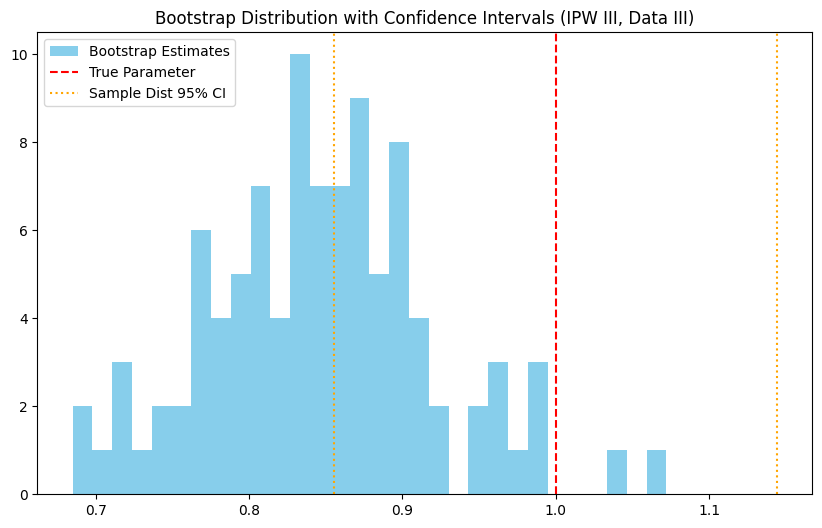

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(pes3, bins=30, alpha=1, color='skyblue', label='Bootstrap Estimates')
plt.axvline(1, color='red', linestyle='--', label='True Parameter')

# for i, (point_est, std) in enumerate(zip(pes3, bootstd)):
#     plt.errorbar(x=point_est, y=i/15, xerr=1.96*std, fmt='o', color='blue', alpha=0.2, capsize=1)

plt.axvline(true_arm_l, color='orange', linestyle=':', label='Sample Dist 95% CI')
plt.axvline(true_arm_r, color='orange', linestyle=':')


plt.title('Bootstrap Distribution with Confidence Intervals (IPW III, Data III)')

plt.legend()
plt.show()